# Image Classification on the AMD Ryzen™ AI using Resnet-50

In [1]:
import requests
from PIL import Image

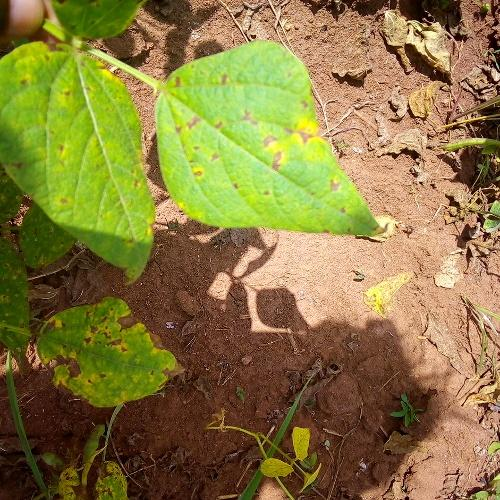

In [2]:
url = "https://datasets-server.huggingface.co/assets/beans/--/default/train/0/image/image.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

## Export the model to ONNX

In [3]:
from pathlib import Path
from optimum.exporters.onnx import main_export
from optimum.amd.ryzenai import RyzenAIModelForImageClassification

c:\Users\Mohit\anaconda3\envs\optimumamd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
task = "image-classification"
model_id = "eugenecamus/resnet-50-base-beans-demo"

onnx_dir = "demo_resnet_onnx"

In [5]:
main_export(
    model_id,
    onnx_dir,
    task=task
)

static_onnx_path = RyzenAIModelForImageClassification.reshape(
    Path(onnx_dir) / "model.onnx",
    input_shape_dict={"pixel_values": [1, 3, 224, 224]},
    output_shape_dict={"logits": [1, 3]},
)


Framework not specified. Using pt to export to ONNX.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\Mohit\anaconda3\envs\optimumamd\lib\site-packages\transformers\models\convnext\feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
Using the export variant default. Available variants are:
	- default: The default ONNX variant.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Using framework PyTorch: 2.1.0+cpu
c:\Users\Mohit\anaconda3\envs\optimumamd\lib\site-packages\transformers\models\resnet\modeling_resnet.py:95: TracerWarning: Converting a tensor to a Python boolean might cause

## Quantize the model

In [6]:
from optimum.amd.ryzenai import RyzenAIOnnxQuantizer

quantizer = RyzenAIOnnxQuantizer.from_pretrained(onnx_dir, file_name=static_onnx_path.name)

In [7]:
from functools import partial
from transformers import AutoFeatureExtractor
from optimum.amd.ryzenai.configuration import QuantizationConfig

# Create the quantization configuration containing all the quantization parameters
qconfig = QuantizationConfig()

feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

def preprocess_fn(ex, feature_extractor):
    return feature_extractor(ex["image"])

# Create the calibration dataset used for the calibration step
calibration_dataset = quantizer.get_calibration_dataset(
    "beans",
    preprocess_function=partial(preprocess_fn, feature_extractor=feature_extractor),
    num_samples=128,
    dataset_split="test",
)

c:\Users\Mohit\anaconda3\envs\optimumamd\lib\site-packages\transformers\models\convnext\feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
c:\Users\Mohit\anaconda3\envs\optimumamd\lib\site-packages\datasets\load.py:2089: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=False' instead.
  warnings.warn(


In [8]:
output_dir = "demo_resnet_onnx_quantized"

quantizer.quantize(
    save_dir=output_dir,
    quantization_config=qconfig,
    dataset=calibration_dataset,
)

Quantizing model...
INFO:root:Finding optimal threshold for each tensor using PowerOfTwoMethod.MinMSE algorithm ...
INFO:root:Remove QuantizeLinear & DequantizeLinear on certain operations(such as conv-relu).
INFO:root:Rescale GlobalAveragePool /resnet/pooler/GlobalAveragePool with factor 1.0048828125 to simulate DPU behavior.
INFO:root:Shift write of layer /resnet/pooler/GlobalAveragePool_output_0_Mul is -6(0-6). It exceeds range [0, 32]. Modify opos from 6 to 0.
INFO:root:Input pos of pooling layer /resnet/pooler/GlobalAveragePool is 3. Output pos of pooling layer /resnet/pooler/GlobalAveragePool is 0.Modify ipos from 3 to 0.
Saved quantized model at: demo_resnet_onnx_quantized
Configuration saved in demo_resnet_onnx_quantized\ryzenai_config.json


WindowsPath('demo_resnet_onnx_quantized')

## Run inference using the quantized model

In [9]:
vaip_config = "vaip_config.json"
model = RyzenAIModelForImageClassification.from_pretrained(output_dir, vaip_config=vaip_config)

The ONNX file model_static_quantized.onnx is not a regular name used in optimum.amd.ryzenai, the RyzenAIModel might not behave as expected.


In [10]:
from transformers import pipeline

cls_pipe = pipeline("image-classification", model=model, feature_extractor=feature_extractor)
cls_pipe(image)

[{'score': 0.635113000869751, 'label': 'angular_leaf_spot'},
 {'score': 0.30000612139701843, 'label': 'bean_rust'},
 {'score': 0.06488087773323059, 'label': 'healthy'}]

In [11]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(model_id)
cls_pipe = pipeline("image-classification", model=model, feature_extractor=feature_extractor)
cls_pipe(image)

[{'score': 0.846971333026886, 'label': 'angular_leaf_spot'},
 {'score': 0.15257897973060608, 'label': 'bean_rust'},
 {'score': 0.0004497455956880003, 'label': 'healthy'}]